In [1]:
#
# This notebook is for the exploration of Logistic Regression -- it corresponds to Lecture Handout 2
#
# You will work in the associated Python module, 'lab_2.py'.

In [2]:
# Autoload setup (you don't need to edit this cell); instructions to: 
#   i) enable autoreloading of modules
%load_ext autoreload
#  ii) import the module 'lab_2' (which will contain your functions) in an autoreloadable way 
%aimport lab_2
# iii) indicate that we want autoreloading to happen on every evaluation.
%autoreload 1

In [3]:
##############################################################
#
# 1: Import modules.
#
##############################################################

import pandas as pd  # Pandas is a library for handling structured numerical data.
import numpy as np   # NumPy (Numerical Python), high-performance vector / matrix computations.

# SciKit-Learn is a module with utility function for data mining & machine learning.
import sklearn.linear_model as skl_lm
from sklearn.metrics import confusion_matrix, classification_report, precision_score

# MatPlotLib provides MATLAB-style plotting utilities.
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.7

%matplotlib inline

In [4]:
##############################################################
#
# 2. Loading the ISLR 'Default' dataset
#
##############################################################

# see https://cran.r-project.org/web/packages/ISLR/ISLR.pdf
#
# This data set contains information on ten thousand bank customers. 
#
# The aim here is to predict which customers will default on their credit card debt.
#
# The dataset contains 10000 observations on the following 4 variables.
#   * 'default': a No/Yes label indicating whether the customer defaulted on their debt
#   * 'student': a No/Yes label indicating whether the customer is a student
#   * 'balance': the average balance that the customer has remaining on their credit card after making
#                their monthly payment
#   * 'income' : income of customer

# We use the 'pandas' package to read the CSV file into what Pandas calls a 'dataframe' (hence 'df').
df = pd.read_csv('Default.csv')

# Eyeball the first 10 observations to make sure the data has been loaded OK.  The 'Unnamed' column
# is the row number contained in the file.
df.head(10)

,Unnamed: 0,default,student,balance,income
0,1,No,No,729.526495,44361.625070
1,2,No,Yes,817.180407,12106.134700
2,3,No,No,1073.549164,31767.138950
3,4,No,No,529.250605,35704.493940
4,5,No,No,785.655883,38463.495880
5,6,No,Yes,919.588530,7491.558572
6,7,No,No,825.513330,24905.226580
7,8,No,Yes,808.667504,17600.451340
8,9,No,No,1161.057854,37468.529290
9,10,No,No,0.000000,29275.268290


/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_base.py:3116: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  alternative='`left`', obj_type='argument')


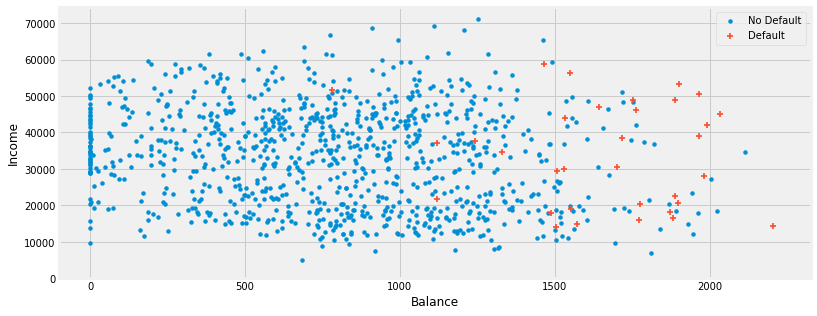

In [5]:
##############################################################
#
# 3. Visualise the data
#
##############################################################

# We need to visualise our data
# We will ignore the categorical feature 'student' and the row number in the first column.
# We'll focus first on the 'balance' and 'income' features.

balance = df['balance'].values
income = df['income'].values

# We'll convert the given outcomes (credit-card default or not) from string to boolean:
y = df['default'].values == 'Yes'

# We'll plot a subset of the data to keep the graph legible:
num_to_plot = 1000;
income_subset = income[0:num_to_plot];
balance_subset = balance[0:num_to_plot];
y_subset = y[0:num_to_plot];

# Set up matplotlib figure:
fig = plt.figure(figsize=(12,5))
ax = plt.gca()

# Scatter plot of balance vs income for the 'No Default' class
non_defaulters = y_subset == False; # Vector of bool, 'true' means non-defaulter
ax.scatter(balance_subset[non_defaulters], income_subset[non_defaulters], s=15, marker='o')

# Scatter plot of balance vs income for the 'Default' class
defaulters = y_subset == True; # Vector of bool, 'true' means defaulter
ax.scatter(balance_subset[defaulters],  income_subset[defaulters],  s=40, marker='+')

# Configure plot axes and labels:
ax.set_ylim(ymin=0)
ax.set_ylabel('Income')
ax.set_xlim(xmin=-100)
ax.set_xlabel('Balance')
ax.legend(['No Default', 'Default'])

# Peer into the scatter plot now in search of insight...
#
# Note that both defaulters and non-defaulters are well-distributed vertically; this 
# suggests that 'income' is not a great predictive factor.  On the other hand, the 
# defaulters are mostly in the high-balance region, and the non-defaulters are found
# in the low-balance region.  So 'balance' is the better candidate as a feature for class prediction.


In [6]:
# Having scrutinized the data, we start to implement a predictor (logistic classifier).

In [7]:
# Exercise 1: implement cross-entropy (in the lab_2 module)
import numpy as np 
import lab_2 
w_test = np.array([0.1, 0.3])
X_test = np.array([[1,1], [1,0]])
y_test = np.array([0, 1])
print(lab_2.cross_entropy(w_test, X_test, y_test))

# Should print 0.77870375 (approx) if your function is working.

0.7787037579081633


In [8]:
# Exercise 2: implement gradient computation (in the lab_2 module)
w_test = np.array([0.1, 0.3])
X_test = np.array([[1,1], [1,0]])
y_test = np.array([0, 1])
print(lab_2.gradient(w_test, X_test, y_test))
# Expected result: [ 0.06183342  0.29934383]

[0.06183342 0.29934383]


In [9]:
# The gradient descent algorithm as explained in page 22.
# The greek letter 'eta' in the slide is here denoted 'learning_rate'
# The method returns updated weights, and also a vector with the loss function evaluated at every 83rd iteration
# (83 was picked just to reduce the amount of data returned).
def gradient_descent(w0, X, y, learning_rate, maxit):
    w = w0
    loss = [];
    for i in range(0, maxit):
        if (i % 83 == 0):
            loss_error = lab_2.cross_entropy(w, X, y)
            loss.append(loss_error)
      
        grad = lab_2.gradient(w,X,y);
        w = w - learning_rate * grad;        
        i = i + 1
        
    return w, loss
        

In [10]:
#
# Setting up the Model and Design Matrix
#

# in this lab we will look at the following model:
# y = [ w0 + w1 * balance > 0]
#
# and ignore the 'income' feature

n = balance.shape[0]
p = 2

X = np.zeros(shape=(n, p))

# The first feature is just the value 1 (with associated weight w0); this captures the base rate.
X[:,0] = 1;

# The second feature is the balance values (with associated weight w1)
X[:,1] = balance[:]

# Gradient Descent algorithms are quite sensitive to initial conditions
# and it is often beneficial to rescale the features to improve the performance. 
#
# In our case we note that balance ranges from 0 to about 2500, which 
# is much larger in magnitude than the first feature (which is simply 1).
# We (arbitrarily) rescale by factor of 1/1000 to make the features be of comparable magnitude.

X[:,1] = X[:,1]/1000;


[-15.71571238   5.3262048 ]
[-11.59731885   6.65149832]
[-10.63971053   5.49188453]


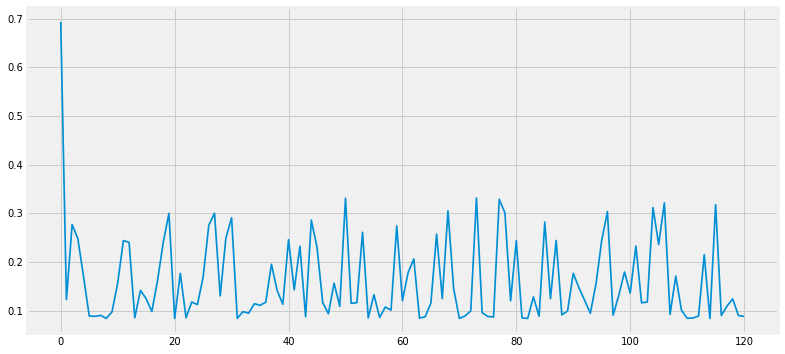

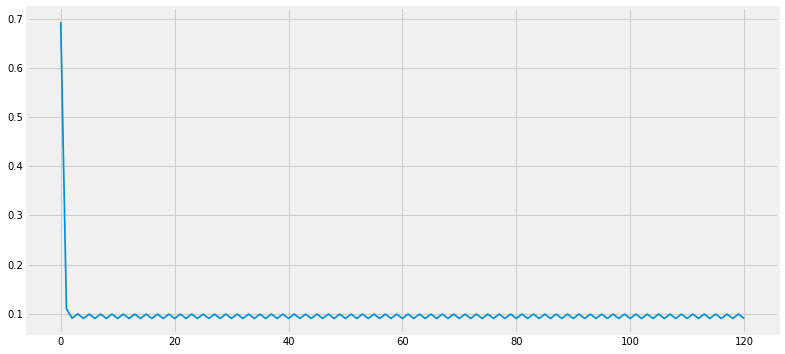

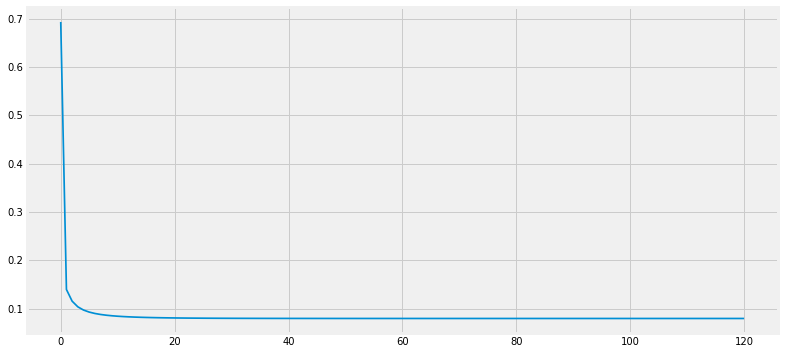

In [11]:
# In the following we are studying the convergence for 3 different learning rates
# This cell might take a while to evaluate!

w0 = [0, 0];
w, loss = gradient_descent(w0, X, y, learning_rate=50, maxit=10000);
print(w)
fig, ax = plt.subplots(1,1, figsize=(12,6))
ax.plot(loss)

w0 = [0, 0];
w, loss = gradient_descent(w0, X, y, learning_rate=30, maxit=10000);
print(w)
fig, ax = plt.subplots(1,1, figsize=(12,6))
ax.plot(loss)

w0 = [0, 0];
w, loss = gradient_descent(w0, X, y, learning_rate=1, maxit=10000);
print(w)
fig, ax = plt.subplots(1,1, figsize=(12,6))
ax.plot(loss)

In [12]:
# Question 3: What is the best learning rate value out of 50, 30 and 1?
# Look at the graphs above to see.  Return your answer from the 'question_3' function in 'lab_2.py'

In [13]:
# A good way to check that if you reached convergence is to check if the gradient is null (or at least very small):
lab_2.gradient(w, X, y)

array([ 6.54752947e-06, -3.96283037e-06])

In [14]:
# In Logistic Regression, we set a parametric model for the likelihood.
# We denote logit = x'w and parametrise the likelihood as
# p(y_i|logit) = 1/(1 + exp(-logit))
#
# We want to verify that this is a correct approximation for our problem
#
# The following function makes an empirical measurement of p(y_i|logit)
# by recording in the dataset the proportion of default=True for 
# a particular logit value (within some small threshold T).
def get_empirical_probability(logit, logits_train, y, T=1):
    valid = ((logits_train <= logit + T) * (logits_train >= logit - T));    
    n_defaults = sum(valid[y==True]);
    n_nodefaults = sum(valid[y==False]);
    empirical_prob = n_defaults / (n_defaults + n_nodefaults);
    return empirical_prob

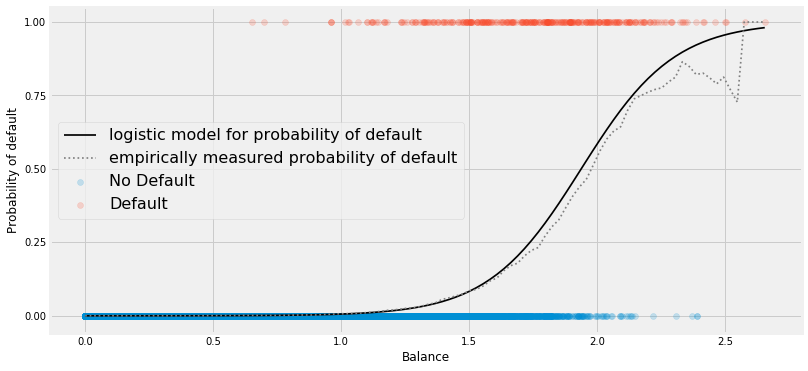

In [15]:
# Testing set: predict the probability of default for 100 values of balance.
import lab_2

n_test = 100
X_test = np.zeros(shape=(n_test,2))
X_test[0:n_test,0] = 1;
X_test[0:n_test,1] = np.linspace(X[:,1].min(), X[:,1].max(), num=n_test)

p_test = lab_2.predict(w, X_test)

# we compute the logit values and their corresponding empirical probabilities of default
logits_test = lab_2.logit(w, X_test)
logits_train = lab_2.logit(w, X)
p_empirical = [get_empirical_probability(logit, logits_train, y) for logit in logits_test ];

# plot the graphs
fig, ax = plt.subplots(1,1, figsize=(12,6))

ax.scatter(X[y==False,1], y[y==False], alpha= 0.2)
ax.scatter(X[y==True,1], y[y==True], alpha= 0.2)
ax.plot(X_test[:,1], p_test, color='black')
ax.plot(X_test[:,1], p_empirical, ':', color='gray')

ax.set_ylabel('Probability of default');
ax.set_xlabel('Balance');
ax.set_yticks([0, 0.25, 0.5, 0.75, 1.]);
ax.legend(['logistic model for probability of default',
           'empirically measured probability of default', 
           'No Default', 'Default'],  prop={'size': 16})


In [21]:
# At this point, we still don't have a classifier. 
# But all we need is to set a threshold on the predicted probabilities.
#
# Exercise 4:
# Flesh out the function 'predict_class' in the module to give
# the predicted class for observations X and weights w.

# Use that function here to assess the accuracy of the classifier
# for different thresholds.
import numpy as np
import lab_2
# Accuracy = percentage correctly classified.
def accuracy(w, X, y, threshold):
    return np.mean(y == lab_2.predict_class(w, X, threshold))

w = np.array([-10.63971053,   5.49188453])   # These are good weights!
print(accuracy(w, X, y, 0.25))
print(accuracy(w, X, y, 0.5))
print(accuracy(w, X, y, 0.75))
print(accuracy(w, X, y, 0.95))

# Update your module function 'question_5' to report the accuracy for a threshold of 0.5.

0.9653
0.9725
0.9698
0.9671
